# A short tutorial on USTC-Pickers (<3 min)
* If any question, please feel free to contact me via email: `zhujun2316@mail.ustc.edu.cn`
* Dependencies: Obspy, PyTorch, [SeisBench v0.3.0](https://github.com/seisbench/seisbench/releases/tag/v0.3.0)

## Load a model

In [12]:
import seisbench
import seisbench.models as sbm
import os
import glob
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from config import (en2cn, model_list)
sample_rate = 50
# 为拾取的目标区域选定合适的picker，如Sichuan（四川）、CSES（实验场）、TP（青藏高原）
location = input('Plase specify a region or province to pick phases, e.g. Beijing. 42 pickers are available in the subfolder "%s"'%os.path.join('USTC-Pickers', 'model_list', 'v0.1'))
if location not in en2cn:
    exit('The region you specified is not available. Plase choose a region or province from below--------\n%s\n-----------------------------------------------------------------------------------------------'%(', '.join(en2cn)))
else:
    model_save_path = glob.glob(os.path.join(model_list, '*'+en2cn[location]+'.pt'))[0]
    print('You are using the picker located at %s\n'%model_save_path)
    # 模型初始化
    picker = sbm.PhaseNet(sampling_rate=sample_rate)
    # 加载模型
    picker.load_state_dict(
        torch.load(
            model_save_path,
            map_location=device).state_dict()
    )

You are using the picker located at ../model_list/v0.1/北京市.pt



/var/folders/50/tw568v5s4lb0yd1_myl2dj_r0000gn/T/ipykernel_90497/2876095227.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


## Read waveforms

In [13]:
from obspy import read
from config import (sac, mseed)

# Read the 3-component waveforms as input
#inputfile = mseed.replace('Beijing', 'Sichuan')
inputfile = mseed.replace('Beijing', '*')
#inputfile = sac.replace('Beijing', 'Sichuan')
#inputfile = sac.replace('Beijing', '*')
print(inputfile)
stream = read(inputfile)
print(stream)

../test_data/mseed/**.mseed
6 Trace(s) in Stream:
CN.BJ..BHE | 2018-07-18T15:24:11.300000Z - 2018-07-18T15:27:11.280000Z | 50.0 Hz, 9000 samples
CN.BJ..BHN | 2018-07-18T15:24:11.300000Z - 2018-07-18T15:27:11.280000Z | 50.0 Hz, 9000 samples
CN.BJ..BHZ | 2018-07-18T15:24:11.300000Z - 2018-07-18T15:27:11.280000Z | 50.0 Hz, 9000 samples
CN.SC..BHE | 2010-03-14T20:34:19.500000Z - 2010-03-14T20:37:19.480000Z | 50.0 Hz, 9000 samples
CN.SC..BHN | 2010-03-14T20:34:19.500000Z - 2010-03-14T20:37:19.480000Z | 50.0 Hz, 9000 samples
CN.SC..BHZ | 2010-03-14T20:34:19.500000Z - 2010-03-14T20:37:19.480000Z | 50.0 Hz, 9000 samples


## Model response (optional)

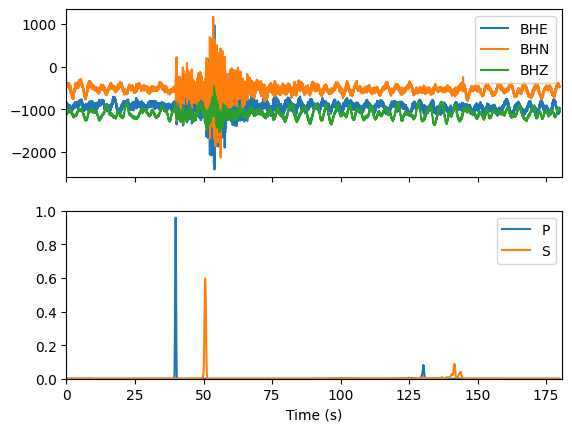

In [14]:
import numpy as np
response = picker.annotate(stream)
# Plot the response
import matplotlib.pyplot as plt

time_diff = response[0].stats.starttime-stream[0].stats.starttime
fig, ax = plt.subplots(2, 1, sharex=True)
t0 = np.arange(stream[0].stats.npts)/sample_rate
t1 = np.arange(response[0].stats.npts)/sample_rate + time_diff
ax[0].plot(t0, np.array([x.data for x in stream[:3]]).transpose(), label=[x.stats.channel for x in stream[:3]])
ax[1].plot(t1, np.array([x.data for x in response[1:3]]).transpose(), label=['P', 'S'])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylim(0, 1)
for j in ax:
    j.legend()
    j.set_xlim(0, t0.max()+1)
plt.show()
plt.close()

## Retrieve the predicted picks

In [15]:
picks = picker.classify(stream, P_threshold=.3, S_threshold=.3)
print('Printing picks')
lines = {phase:{'trace':[],'time':[]} for phase in 'PS'}
def format_utc(t):
    return '%04d%02d%02dT%02d:%02d:%02d.%02d'%(t.year,t.month,t.day,t.hour,t.minute,t.second,t.microsecond/1e4)
for pick in picks:
    print(pick)
    # Please ensure both the station and network code exist in the header of the SAC files
    lines[pick.phase]['trace'].append(pick.trace_id)
    lines[pick.phase]['time'].append(format_utc(pick.peak_time))
print(lines)
import json
# save results as json
with open('results/picks_demo.json','w') as fp:
    json.dump(lines,fp)
# read results as dict
with open('results/picks_demo.json','r') as fp:
    data = json.load(fp)

Printing picks
CN.SC.	2010-03-14T20:35:00.920000Z	S
CN.BJ.	2018-07-18T15:25:01.920000Z	S
CN.SC.	2010-03-14T20:34:55.260000Z	P
CN.BJ.	2018-07-18T15:24:51.140000Z	P
{'P': {'trace': ['CN.SC.', 'CN.BJ.'], 'time': ['20100314T20:34:55.26', '20180718T15:24:51.14']}, 'S': {'trace': ['CN.SC.', 'CN.BJ.'], 'time': ['20100314T20:35:00.92', '20180718T15:25:01.92']}}
